<a href="https://colab.research.google.com/github/markste-in/collatz/blob/main/Dataset_NN_Colab_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with",device)

Working with cuda


In [4]:
import pandas as pd

In [7]:
import glob
files = glob.glob("gdrive/MyDrive/collatz_dbs/*.parquet")


In [8]:
 data = [pd.read_parquet(f) for f in files]
 df = pd.concat(data,ignore_index=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000000 entries, 0 to 7999999
Data columns (total 30 columns):
 #   Column              Dtype
---  ------              -----
 0   Number              int64
 1   Length              int64
 2   Max                 int64
 3   IsEven              bool 
 4   nPrimes             int64
 5   Smallest_Prime      int64
 6   nSmallest_Prim      int64
 7   Biggest_Prime       int64
 8   nBiggest_Prime      int64
 9   isPrime             bool 
 10  preNumber           int64
 11  preLength           int64
 12  preMax              int64
 13  preIsEven           bool 
 14  prenPrimes          int64
 15  preSmallest_Prime   int64
 16  prenSmallest_Prim   int64
 17  preBiggest_Prime    int64
 18  prenBiggest_Prime   int64
 19  preisPrime          bool 
 20  postNumber          int64
 21  postLength          int64
 22  postMax             int64
 23  postIsEven          bool 
 24  postnPrimes         int64
 25  postSmallest_Prime  int64
 26  postnSmallest_

In [10]:
df.sample(5)

,Number,Length,Max,IsEven,nPrimes,Smallest_Prime,nSmallest_Prim,Biggest_Prime,nBiggest_Prime,isPrime,preNumber,preLength,preMax,preIsEven,prenPrimes,preSmallest_Prime,prenSmallest_Prim,preBiggest_Prime,prenBiggest_Prime,preisPrime,postNumber,postLength,postMax,postIsEven,postnPrimes,postSmallest_Prime,postnSmallest_Prim,postBiggest_Prime,postnBiggest_Prime,postisPrime
286028,8709500,181,33068896,True,3,2,2,17419,1,False,8709499,93,44091844,False,3,71,1,509,1,False,8709501,181,33068896,False,3,3,1,21191,1,False
4556651,2177566,117,11023936,True,2,2,1,1088783,1,False,2177565,117,6532696,False,4,3,1,859,1,False,2177567,179,33071812,False,3,7,1,4643,1,False
5050095,8479790,106,28619296,True,5,2,1,607,1,False,8479789,106,25439368,False,2,641,1,13229,1,False,8479791,168,85857892,False,2,3,2,942199,1,False
4149277,5169060,100,18629656,True,5,2,2,47,2,False,5169059,113,23260768,False,2,7,2,105491,1,False,5169061,100,18629656,False,1,5169061,1,5169061,1,True
5740170,3319947,177,80765908,False,3,3,4,2411,1,False,3319946,115,4979920,True,4,2,1,1783,1,False,3319948,115,3734944,True,2,2,2,829987,1,False


In [11]:
x =df.loc[:, df.columns != 'Length'].values.astype('int64')
y = df["Length"].values
x = torch.tensor(x).float().to(device)
y = torch.tensor(y).float().to(device)

In [12]:
input_size = x.shape[1]
class NN(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(input_size,800)
        self.b1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.b22 = nn.BatchNorm1d(800)
        self.fc22 = nn.Linear(800,400)
        self.b2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.b1(x)
        x = F.relu(self.fc2(x))
        x = self.b22(x)
        x = F.relu(self.fc22(x ))
        x = self.b2(x)
        x = self.fc3(x)

        return x

def collatz_iter(n : int) -> int:
    iter = 0
    while (n>1):
        if n%2 == 0:
            n =n / 2
        else:
            n = n*3+1
        iter+=1
    return iter


In [13]:
PATH =  "gdrive/MyDrive/collatz_model2.pt"

In [14]:
batch_size = 300
model = NN().to(device)
opt = torch.optim.Adam(params=model.parameters(),lr = 0.1)
losses = list()


In [15]:
try:
  model.load_state_dict(torch.load(PATH,map_location=torch.device(device)))
  print("Previous model loaded")
except:
  print("No old model found. Train from scratch")

No old model found. Train from scratch


In [16]:
def batches(x,y, batch_size = 32):
  idx = np.random.randint(1,x.shape[0],batch_size)
  return x[idx,:],y[idx]

In [17]:
t = tqdm.trange(1000000, desc='Bar desc', leave=True)
for i in t:
    _x, _y = batches(x,y)
    opt.zero_grad()
    pred = model(_x)
    loss = ((_y-pred)**2).sum()
    loss.backward()
    losses.append(loss.cpu().detach().numpy())
    opt.step()
    if i%100 ==0:
      torch.save(model.state_dict(), PATH)
    if i%30==0:
      t.set_description("Last loss %i" % losses[-1])
      t.refresh() # to show immediately the update

Last loss 4541233: 100%|██████████| 1000000/1000000 [1:25:22<00:00, 195.23it/s]


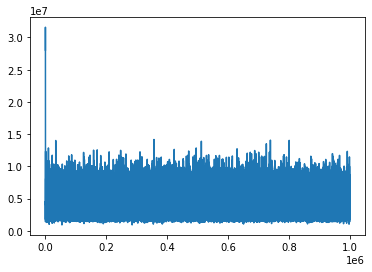

In [18]:
plt.plot(losses)
#plt.yscale("log")
plt.show()

In [22]:
x[1,:]

tensor([3.0235e+04, 5.1662e+05, 0.0000e+00, 2.0000e+00, 5.0000e+00, 1.0000e+00,
        6.0470e+03, 1.0000e+00, 0.0000e+00, 3.0234e+04, 8.5000e+01, 4.5352e+04,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00, 5.0390e+03, 1.0000e+00,
        0.0000e+00, 3.0236e+04, 1.3400e+02, 5.1028e+04, 1.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 7.5590e+03, 1.0000e+00, 0.0000e+00],
       device='cuda:0')

In [20]:
_y,pred

(tensor([110., 160.,  95.,  93.,  80., 261., 201., 153.,  75., 191., 142., 137.,
         172., 118., 147., 189., 108.,  90., 105., 173., 190.,  98., 144., 225.,
         147., 151., 105.,  93., 143., 162., 138., 216.], device='cuda:0'),
 tensor([[151.5828],
         [151.5785],
         [151.5715],
         [151.5710],
         [153.0688],
         [151.5838],
         [152.0977],
         [151.5769],
         [151.5843],
         [151.5786],
         [151.5786],
         [151.5751],
         [151.5739],
         [151.5748],
         [152.0935],
         [151.5758],
         [151.5750],
         [152.0225],
         [151.5935],
         [151.6558],
         [151.9326],
         [151.6104],
         [151.5747],
         [151.5855],
         [151.5748],
         [156.8568],
         [152.0018],
         [151.5748],
         [151.5780],
         [151.5748],
         [151.5776],
         [156.6312]], device='cuda:0', grad_fn=<AddmmBackward>))

In [23]:
for i in range(10):
  test = torch.tensor(np.random.randint(1e7))
  print(test - test.float().int())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
